# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.


Несмотря на то, что основная причина использования Negative Sampling - улучшение скорости тренировки word2vec, в нашем игрушечном примере мы **не требуем** улучшения производительности. Мы используем negative sampling просто как дополнительное упражнение для знакомства с PyTorch.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import random

import matplotlib.pyplot as plt
from word2vec_trainer import Trainer

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os


class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
superbly ['graham', 'greene']
slapping ['be', 'ends']
anybody ['enjoys', 'quirky']
hilarious ['-lrb-', 'comedy']
near-disaster ['account', 'the', '...', 'done']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [3]:
num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        self.data = data
        self.num_contexts = num_contexts
        self.samples = []
        self.num_tokens = len(self.data.index_by_token)
        self.num_negative_samples = num_negative_samples
        
        # TODO: Implement what you need for other methods!
    
    def generate_dataset(self, context_length=5):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        for step in range(self.num_contexts):
            center_word, context_words = data.get_random_context(context_length)

            for word in other_words:
                negative_indices = []

                while len(negative_indices) < num_negative_samples:
                    generated_index = random.randrange(self.num_tokens)
                    generated_word = self.data.token_by_index[generated_index]

                    if not (generated_word in other_words):
                        negative_indices.append(generated_index)
                
                sample = (self.data.index_by_token[center_word], [self.data.index_by_token[word], *negative_indices])
                self.samples.append(sample)
    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, index):
        input_vector, output_vector = self.samples[index]

        output_indices = torch.tensor(output_vector)
        output_target = torch.zeros_like(output_indices)
        output_target[0] = 1.0
        return input_vector, output_indices, output_target

dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()

input_vector, output_indices, output_target = dataset[0]
print(type(input_vector), type(output_indices), type(output_target))
print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

<class 'int'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Sample - input: 17766, output indices: tensor([ 1412,  8609, 18995,  5806,  8346,  8250,  8202,  8308, 15803, 10998,
         2543]), output target: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.  
Напомним, что цели улучшить скорость тренировки у нас нет, достаточно чтобы она сходилась.

In [4]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()

# As before, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens, device):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, 10, bias=False).to(device)
        self.ouput = nn.Linear(10, num_tokens, bias=False).to(device)
        self.num_tokens = num_tokens
        self.device = device
        
    def forward(self, input_index_batch, output_indices_batch):
        results = []
        for input_index, output_index in zip(input_index_batch, output_indices_batch):
            sample = torch.zeros(self.num_tokens).to(self.device)
            sample[input_index] = 1.0

            input_results = self.input(sample).to(self.device)
            output_results = self.ouput(input_results).to(self.device)
            results.append(output_results[output_index])
        results_tensor = torch.stack(results)
        
        return results_tensor

In [5]:
cuda = "cuda:0"
cpu = "cpu"
device = torch.device(cuda) # Let's make sure GPU is available!
nn_model = Word2VecNegativeSamples(data.num_tokens(), device)
nn_model.type(torch.FloatTensor)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (ouput): Linear(in_features=10, out_features=19538, bias=False)
)

In [6]:
def extract_word_vectors(nn_model):
    input_vectors, output_vectors = nn_model.input.weight.T, nn_model.ouput.weight
    return torch.clone(input_vectors), torch.clone(output_vectors)

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

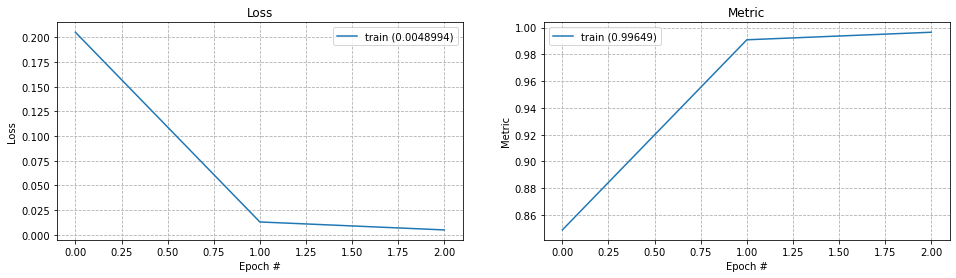

In [7]:
num_negative_samples = 10
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()
batchsize=60

# TODO: We use placeholder values for hyperparameters - you will need to find better values!

# optimizer = optim.Adagrad(nn_model.parameters(), lr=3e0, weight_decay=0)
optimizer = optim.SGD(nn_model.parameters(), momentum=0.95, lr=1e1, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.4)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize)

loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)


trainer = Trainer(model=nn_model, train_loader=train_loader, dataset=dataset, batchsize=batchsize, neg_samp=True)
trainer.train(opt=optimizer,
              loss_fn=loss,
              device=device,
              metric_fn=Trainer.binary_accuracy,
              scheduler=scheduler,
              epochs=3)

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

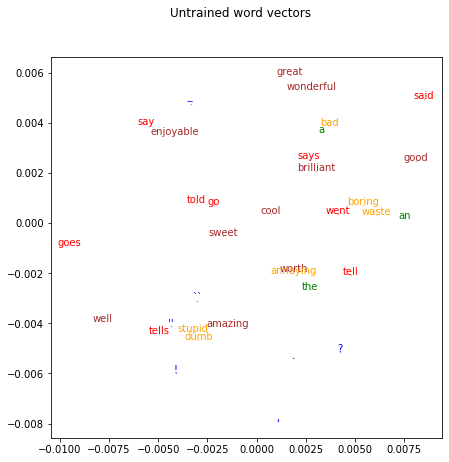

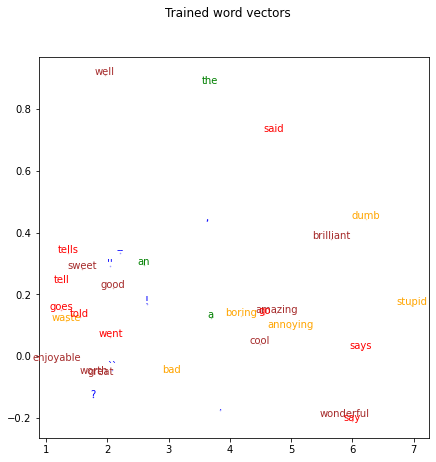

In [8]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.cpu().detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")